## Predicted ionospheric range delay (for different SAR bands and range bandwidths)

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt, ticker
from tools.simulation import iono
plt.rcParams.update({'font.size': 12})

work_dir = os.path.expanduser('~/Papers/2021_Geolocation/figs_src')
os.chdir(work_dir)
print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/Papers/2021_Geolocation/figs_src


In [2]:
# constants
K = 40.31
Re = 6371e3   # earth radius in meters
speed_of_light = 299792458 # speed of light in m / s

# SAR parameters
bnames = ['L', 'S', 'C', 'X']
freqs = [1.257e9, 3.2e9, 5.405e9, 9.65e9]  #carrier frequency for NISAR-L/-S, S1 and TSX
rg_bandwidths = [24e6, 44e6, 80e6]         #range bandwidth (sampling frequency) in Hz
inc_angle = 42                             #LOS incidence angle on the ground in deg
height = 747e3                             #NISAR altitude in meters

inc_angle_iono = iono.incidence_angle_ground2iono(inc_angle)
print('center incidence angle on the ground    : {:.1f} deg'.format(inc_angle))
print('center incidence angle on the ionosphere: {:.1f} deg'.format(inc_angle_iono))

def vtec2range_delay(vtec, inc_angle, freq):
    # convert to TEC in LOS based on equation (3) in Chen and Zebker (2012)
    los_tec = vtec / np.cos(inc_angle * np.pi / 180.)
    # calculate range delay based on equation (1) in Chen and Zebker (2012)
    range_delay = (los_tec * 1e16 * K / (freq**2)).astype(np.float32)
    return range_delay

# Numbers for 20 TECU
VTEC = 20

# geocoding
print('-'*50)
rg_delays = [vtec2range_delay(VTEC, inc_angle_iono, freq) for freq in freqs]
for rg_delay, bname in zip(rg_delays, bnames):
    times = rg_delays[0] / rg_delay
    print(f'20 TECU -> {rg_delay:.1f} m for {bname}-band (1 / {times:.0f} of L-band).')

# coregistration at L-band
print('-'*50)
for rg_bw in [24e6, 44e6, 80e6]:
    rg_delay_pix = rg_delays[0] / (speed_of_light / rg_bw / 2)
    print(f'20 TECU -> {rg_delay_pix:.1f} pixels for L-band.')

# coregistration at S-/C-/X-bands (NISAR-S, S1 and TSX)
print('-'*50)
for rg_delay, bname, rg_bw in zip(rg_delays[1:], bnames[1:], [75e6, 64.35e6, 109.89e6]):
    rg_delay_pix = rg_delay / (speed_of_light / rg_bw / 2)
    print(f'20 TECU -> {rg_delay_pix:.1f} pixels for {bname}-band with range bandwidth of {rg_bw/1e6} MHz.')

center incidence angle on the ground    : 42.0 deg
center incidence angle on the ionosphere: 38.7 deg
--------------------------------------------------
20 TECU -> 6.5 m for L-band (1 / 1 of L-band).
20 TECU -> 1.0 m for S-band (1 / 6 of L-band).
20 TECU -> 0.4 m for C-band (1 / 18 of L-band).
20 TECU -> 0.1 m for X-band (1 / 59 of L-band).
--------------------------------------------------
20 TECU -> 1.0 pixels for L-band.
20 TECU -> 1.9 pixels for L-band.
20 TECU -> 3.5 pixels for L-band.
--------------------------------------------------
20 TECU -> 0.5 pixels for S-band with range bandwidth of 75.0 MHz.
20 TECU -> 0.2 pixels for C-band with range bandwidth of 64.35 MHz.
20 TECU -> 0.1 pixels for X-band with range bandwidth of 109.89 MHz.


## Plot

save figure to file /Users/yunjunz/Papers/2021_Geolocation/figs_src/docs/iono2delay.pdf


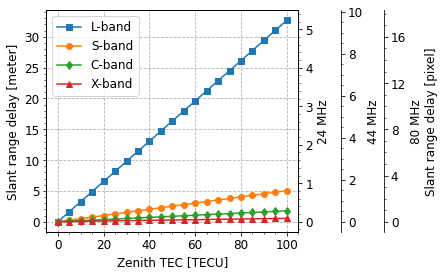

In [7]:
TEC = np.linspace(0, 100, 21)          #iono in TECU

# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7, 4])

## range delay in meters
for i, (bname, freq, marker, mfc) in enumerate(zip(bnames,
                                                   freqs,
                                                   ['s-', 'o-', 'd-', '^-'],
                                                   ['C0', 'C1', 'C2', 'C3'])):
    rg_delay_m = vtec2range_delay(TEC, inc_angle_iono, freq)
    ax.plot(TEC, rg_delay_m, marker, color=mfc, label='{}-band'.format(bname))

# axis format
#ax.set_xlim(0, 100)
#ax.set_ylim(-2, 28)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Zenith TEC [TECU]')
ax.set_ylabel('Slant range delay [meter]')
ax.legend()
ax.grid('on', linestyle='--')

## range delay in pixels
for i, (rg_bandwidth, ystep) in enumerate(zip(rg_bandwidths, [1, 2, 4])):
    # add y-axis
    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.0+0.17*i))
    ax2.tick_params(which='both', axis='y')
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(ystep))
    ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    # ylabel
    label = '{:.0f} MHz'.format(rg_bandwidth/1e6)
    if i == len(rg_bandwidths) - 1:
        label += '\nSlant range delay [pixel]'
    ax2.set_ylabel(label)

    # ylim sync btw. ax and ax2
    rg_pixel_size = speed_of_light / rg_bandwidth / 2
    #rg_delay_p = rg_delay_m / rg_pixel_size
    #ratio = ((np.max(rg_delay_p) - np.min(rg_delay_p)) / (np.max(rg_delay_m)   - np.min(rg_delay_m)))
    ratio = 1. / rg_pixel_size
    ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'docs/iono2delay.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()